<a href="https://colab.research.google.com/github/Aristermans/apisvuelos/blob/main/Te_damos_la_bienvenida_a_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving Online Retail.xlsx to Online Retail.xlsx


# "Online Retail"
Este dataset contiene datos de transacciones de una tienda online del Reino Unido entre 2010 y 2011.

📊 Características del dataset:
InvoiceNo: Número de factura

StockCode: Código del producto

Description: Nombre del producto

Quantity: Cantidad comprada

InvoiceDate: Fecha de la compra

UnitPrice: Precio unitario

CustomerID: ID del cliente

Country: País



In [2]:

install.packages("readxl", repos='http://cran.us.r-project.org')
install.packages("h2o", repos='http://cran.us.r-project.org')
library(readxl)
library(h2o)

# Leer el archivo (ajusta el nombre si subiste otro)
datos <- read_excel("Online Retail.xlsx")

# Mostrar las primeras filas
head(datos)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom


In [3]:

# Elimina NA
datos <- na.omit(datos)

# Crea columna TotalVentas (ajusta según columnas de tu archivo)
datos$TotalVentas <- datos$Quantity * datos$UnitPrice

# Verifica
summary(datos$TotalVentas)


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-168469.6       4.2      11.1      20.4      19.5  168469.6 

In [4]:

h2o.init()
datos_h2o <- as.h2o(datos)



H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/Rtmp5L8ZgK/file56b361afb59/h2o_UnknownUser_started_from_r.out
    /tmp/Rtmp5L8ZgK/file56b18ee9fad/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: ..... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         3 seconds 907 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.44.0.3 
    H2O cluster version age:    1 year, 5 months and 20 days 
    H2O cluster name:           H2O_started_from_R_root_ulh137 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.17 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R V

Warning message in h2o.clusterInfo():
“
Your H2O cluster version is (1 year, 5 months and 20 days) old. There may be a newer version available.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html”



  |======================================================================| 100%


InvoiceNo: Número de factura

Description: Nombre del producto

InvoiceDate: Fecha de la compra

CustomerID: ID del cliente


In [5]:

# Define variables
y <- "TotalVentas"
x <- setdiff(names(datos_h2o), c("InvoiceNo", "InvoiceDate", "Description", "CustomerID", y))

# Divide datos
splits <- h2o.splitFrame(datos_h2o, ratios = 0.8, seed = 123)
train <- splits[[1]]
test <- splits[[2]]

# Modelo de red neuronal
modelo_nn <- h2o.deeplearning(
  x = x, y = y,
  training_frame = train,
  activation = "RectifierWithDropout",
  hidden = c(100, 100),
  epochs = 20,
  seed = 123
)


Warning message in .h2o.processResponseWarnings(res):
“Dropping bad and constant columns: [StockCode, Country].
”


  |======================================================================| 100%


In [6]:

perf <- h2o.performance(modelo_nn, newdata = test)
print(h2o.rmse(perf))  # Error cuadrático medio


[1] 517.7921


In [8]:

predicciones <- h2o.predict(modelo_nn, newdata = test)
predicciones_df <- as.data.frame(predicciones)
head(predicciones_df)


  |======================================================================| 100%


,predict
,<dbl>
1,13.66954
2,46.83160
3,24.49170
4,50.64415
5,38.62861
6,35.42170


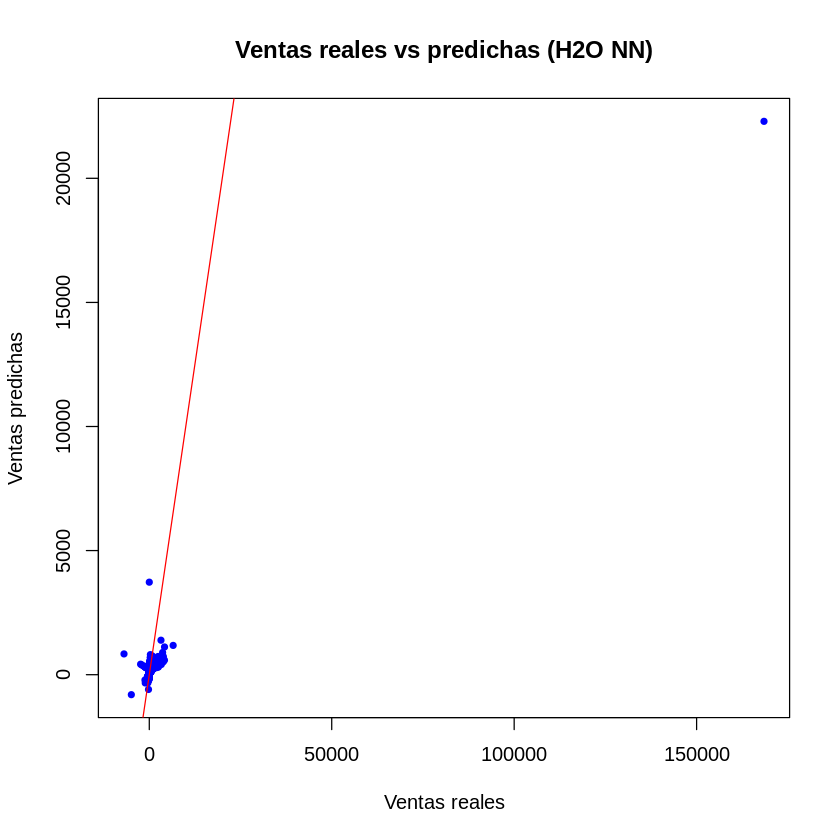

In [9]:

reales <- as.data.frame(test[[y]])
plot(reales[[1]], predicciones_df[[1]], col="blue", pch=20,
     xlab = "Ventas reales", ylab = "Ventas predichas",
     main = "Ventas reales vs predichas (H2O NN)")
abline(0, 1, col="red")


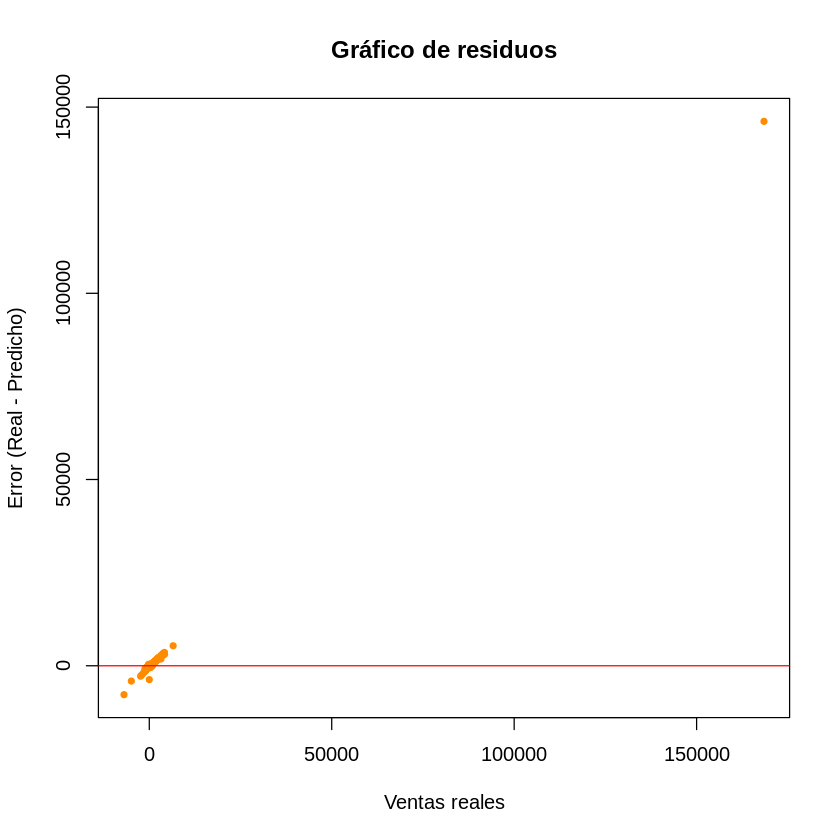

In [10]:

# Cálculo del error
errores <- reales[[1]] - predicciones_df[[1]]

# Gráfico
plot(reales[[1]], errores, col = "darkorange", pch = 20,
     xlab = "Ventas reales", ylab = "Error (Real - Predicho)",
     main = "Gráfico de residuos")
abline(h = 0, col = "red")


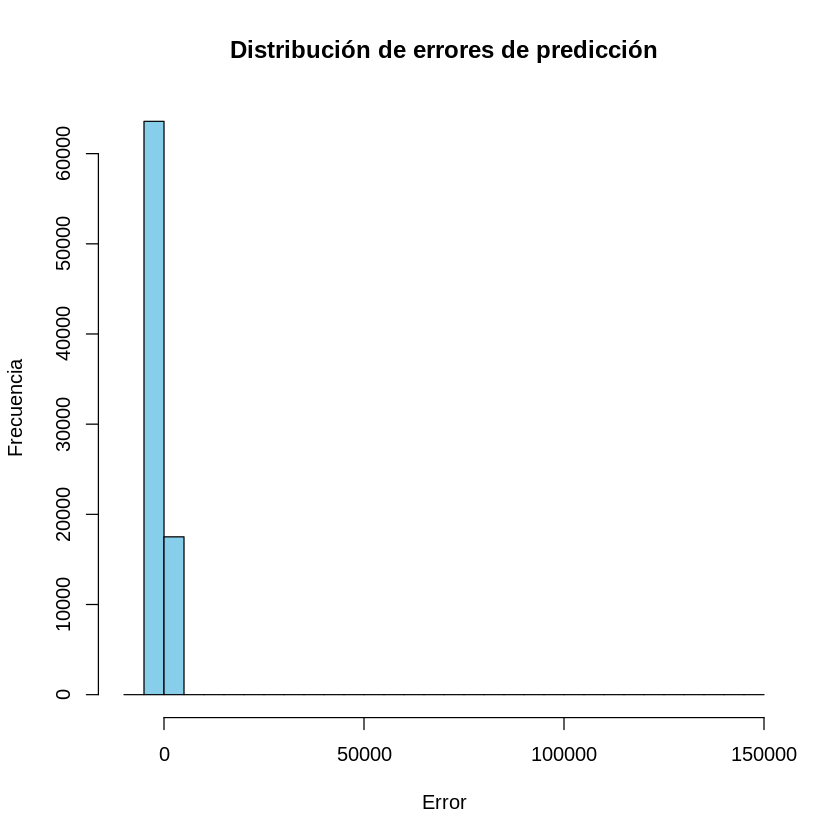

In [11]:

hist(errores, breaks = 30, col = "skyblue",
     main = "Distribución de errores de predicción",
     xlab = "Error", ylab = "Frecuencia")


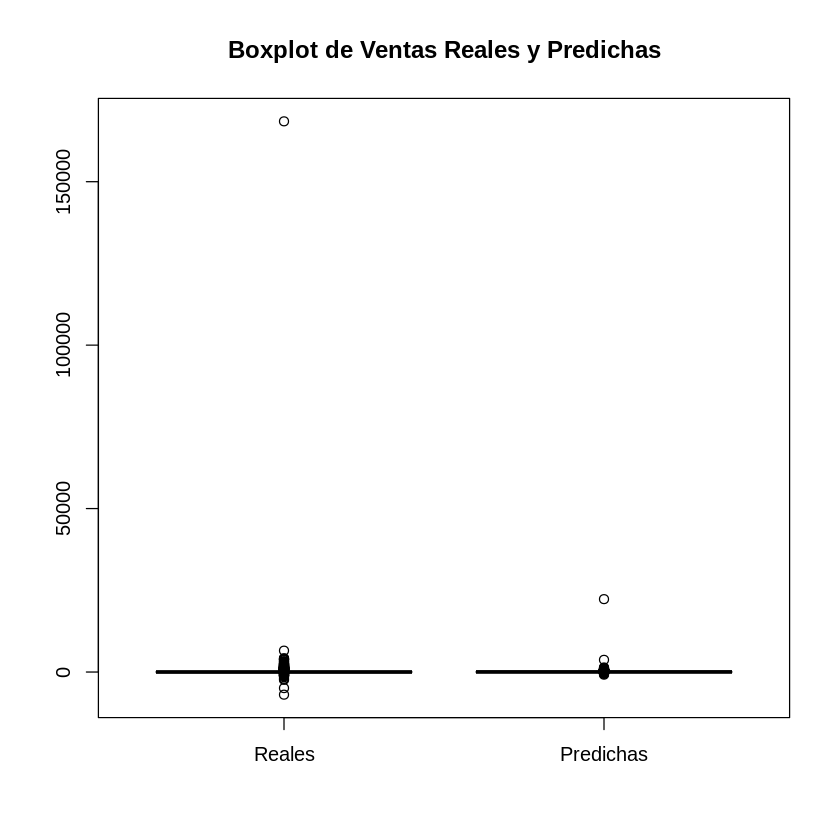

In [12]:

boxplot(reales[[1]], predicciones_df[[1]],
        names = c("Reales", "Predichas"),
        col = c("lightgreen", "lightblue"),
        main = "Boxplot de Ventas Reales y Predichas")


In [13]:
# Ver número total de filas (observaciones) y columnas (variables)
dim(datos)  # Asumiendo que tu dataset se llama 'datos'

# O si el nombre es diferente, usa este para verlo primero
# head(nombre_archivo_excel)  # para ver el nombre de las variables

# Si ya hiciste una partición como esta:
set.seed(123)
index <- sample(1:nrow(datos), size = 0.8 * nrow(datos))
train <- datos[index, ]
test <- datos[-index, ]

# Tamaño de cada subconjunto
cat("Total de datos:", nrow(datos), "\n")
cat("Datos de entrenamiento:", nrow(train), "\n")
cat("Datos de prueba:", nrow(test), "\n")


[1] 406829      9

Total de datos: 406829 
Datos de entrenamiento: 325463 
Datos de prueba: 81366 


In [16]:
summary(as.data.frame(datos_h2o)$TotalVentas)


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-168469.6       4.2      11.1      20.4      19.5  168469.6 

In [15]:
# RMSE
rmse <- sqrt(517.7921)
cat("RMSE:", rmse, "\n")  # Esto te dirá el error promedio en las unidades originales



RMSE: 22.75505 
